In [1]:
import json
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.base import BaseEstimator, TransformerMixin

# Gensim for Dense Embeddings
from gensim.models import Word2Vec

# NLTK downloads
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# --- MANDATORY: REPRODUCIBILITY (Section 3.1.3) ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# ==========================================
# 1. DATA LOADING & LABEL ENGINEERING
# ==========================================
def load_and_parse_data(filepath):
    """
    Parses nested JSON and applies Majority Voting for labels.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.reset_index().rename(columns={'index': 'id_EXIST'})
    
    # Label Processing (Majority Voting)
    if 'labels_task1_1' in df.columns:
        def get_majority_vote(labels_list):
            if not isinstance(labels_list, list): return np.nan
            counts = pd.Series(labels_list).value_counts()
            # Tie-breaking: Prioritize 'YES' (Sexism) if tie
            if len(counts) > 1 and counts.iloc[0] == counts.iloc[1]:
                if 'YES' in counts.index[:2]: return 'YES'
            return counts.idxmax()
        
        df['final_label_str'] = df['labels_task1_1'].apply(get_majority_vote)
        df['label'] = df['final_label_str'].map({'YES': 1, 'NO': 0})
        df = df.dropna(subset=['label'])
        df['label'] = df['label'].astype(int)
        
    return df

print("Loading Data...")
df_train = load_and_parse_data('../data/training/EXIST2025_training.json')
df_val = load_and_parse_data('../data/dev/EXIST2025_dev.json')
# df_test = load_and_parse_data('../data/test/EXIST2025_test.json')

print(f"Total Samples - Training: {len(df_train)}")
print(df_train['final_label_str'].value_counts())

print(f"Total Samples - Validation: {len(df_val)}")
print(df_val['final_label_str'].value_counts())

# print(f"Total Samples - Validation: {len(df_test)}")
# print(df_test['final_label_str'].value_counts())

Loading Data...
Total Samples - Training: 6920
final_label_str
YES    3553
NO     3367
Name: count, dtype: int64
Total Samples - Validation: 1038
final_label_str
YES    559
NO     479
Name: count, dtype: int64


In [3]:
# ==========================================
# 2. PREPROCESSING ABLATION STUDY (Section 4.2)
# ==========================================
print("\n--- 4.2 PREPROCESSING ABLATION STUDY ---")

stop_words = set(stopwords.words('english')) | set(stopwords.words('spanish'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, strategy='raw'):
    """
    Implements the specific strategies defined in Section 4.2.1
    """
    text = str(text)
    
    if strategy == 'raw':
        return text
        
    if strategy == 'lowercase':
        return text.lower()
        
    if strategy == 'no_punct':
        # Remove punctuation, keep spaces
        text = re.sub(r'[^\w\s]', '', text)
        return text.lower()
        
    if strategy == 'no_stopwords':
        text = text.lower()
        words = text.split()
        return " ".join([w for w in words if w not in stop_words])
        
    if strategy == 'stemmed':
        text = text.lower()
        words = text.split()
        return " ".join([stemmer.stem(w) for w in words])
        
    if strategy == 'lemmatized':
        text = text.lower()
        # Simple tokenization for lemmatizer
        words = text.split() 
        return " ".join([lemmatizer.lemmatize(w) for w in words])
        
    return text

# We need to split data FIRST to avoid data leakage (Section 3.1)
# Using 'raw' text as the base source
X_train_raw = df_train['tweet']
y_train = df_train['label']

X_val_raw = df_val['tweet']
y_val = df_val['label']

# X_test_raw = df_test['tweet']
# y_test = df_test['label']

# Stratified Split (Section 3.1.2)
# X_train_raw, X_test_raw, y_train, y_test = train_test_split(
#     X_raw, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
# )

strategies = ['raw', 'lowercase', 'no_punct', 'no_stopwords', 'stemmed', 'lemmatized']
ablation_results = {}

for strat in strategies:
    print(f"Testing strategy: {strat}...")
    # Apply preprocessing
    X_train_curr = [preprocess_text(text, strat) for text in X_train_raw]
    
    # Pipeline: TF-IDF (Default) + LR (Default)
    pipe = Pipeline([
        ('vect', TfidfVectorizer()),
        ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])
    
    # 5-Fold Stratified CV (Section 3.4.1)
    scores = cross_val_score(pipe, X_train_curr, y_train, cv=5, scoring='f1_macro')
    ablation_results[strat] = scores.mean()

print("\nPreprocessing Results (F1-Macro):")
for k, v in ablation_results.items():
    print(f"{k}: {v:.4f}")

# Select best strategy for subsequent steps
best_strategy = max(ablation_results, key=ablation_results.get)
print(f"\nBest Strategy Selected: {best_strategy}")

# Prepare Data with Best Strategy
X_train = [preprocess_text(t, best_strategy) for t in X_train_raw]
X_val = [preprocess_text(t, best_strategy) for t in X_val_raw]
# X_test = [preprocess_text(t, best_strategy) for t in X_test_raw]


--- 4.2 PREPROCESSING ABLATION STUDY ---
Testing strategy: raw...
Testing strategy: lowercase...
Testing strategy: no_punct...
Testing strategy: no_stopwords...
Testing strategy: stemmed...
Testing strategy: lemmatized...

Preprocessing Results (F1-Macro):
raw: 0.6506
lowercase: 0.6506
no_punct: 0.6449
no_stopwords: 0.6496
stemmed: 0.6493
lemmatized: 0.6472

Best Strategy Selected: raw


In [25]:
# ==========================================
# 3. N-GRAM EXPLORATION (Section 4.1)
# ==========================================
print("\n--- 4.1 N-GRAM EXPLORATION ---")
ngram_configs = [(1, 2), (1, 1), (1, 3), (2, 2)]
ngram_results = {}

for ngram in ngram_configs:
    pipe = Pipeline([
        ('vect', TfidfVectorizer(ngram_range=ngram)),
        ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_macro')
    ngram_results[str(ngram)] = scores.mean()
    print(f"N-gram {ngram}: F1-Macro = {scores.mean():.4f}")

best_ngram = ast.literal_eval(max(ngram_results, key=ngram_results.get))


--- 4.1 N-GRAM EXPLORATION ---
N-gram (1, 2): F1-Macro = 0.6276
N-gram (1, 1): F1-Macro = 0.6506
N-gram (1, 3): F1-Macro = 0.6124
N-gram (2, 2): F1-Macro = 0.5597



--- 4.3 HYPERPARAMETER OPTIMIZATION ---
Running Grid Search...
Best Params: {'clf__C': 1, 'vect__max_features': None, 'vect__ngram_range': (1, 1)}
Best F1-Macro: 0.6506


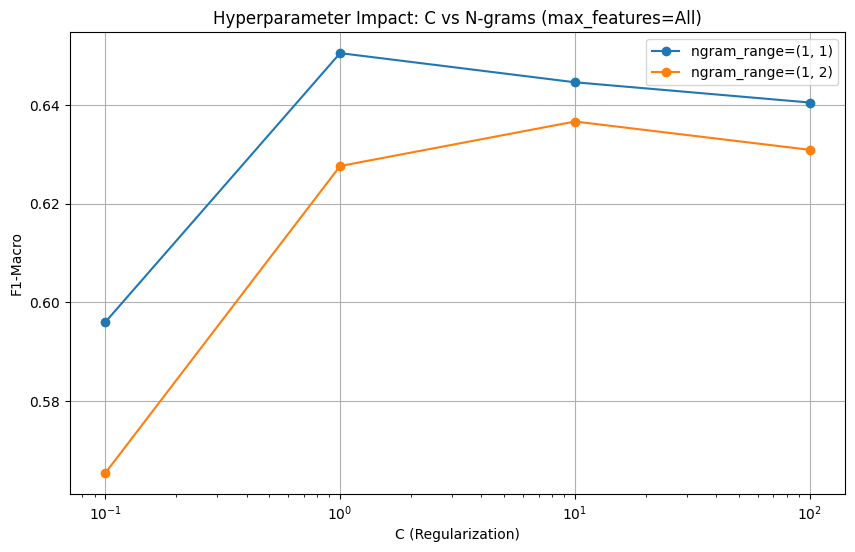

In [22]:
# ==========================================
# 4. HYPERPARAMETER OPTIMIZATION (Section 4.3)
# ==========================================
print("\n--- 4.3 HYPERPARAMETER OPTIMIZATION ---")

# Pipeline
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

# Grid Search Space (Section 4.3.3)
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)], # Narrowed slightly for speed, expand if needed
    'vect__max_features': [5000, 10000, None],
    'clf__C': [0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='f1_macro', 
    n_jobs=-1,
    return_train_score=False
)

print("Running Grid Search...")
grid_search.fit(X_train, y_train)

print(f"Best Params: {grid_search.best_params_}")
print(f"Best F1-Macro: {grid_search.best_score_:.4f}")

# --- Visualization (Section 4.3.4) ---
results_df = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(10, 6))
# Filter for visualization (e.g., max_features=None)
subset = results_df[results_df['param_vect__max_features'].isnull()]

for ngram in [(1,1), (1,2)]:
    mask = subset['param_vect__ngram_range'] == ngram
    plt.plot(
        subset[mask]['param_clf__C'], 
        subset[mask]['mean_test_score'], 
        marker='o', 
        label=f'ngram_range={ngram}'
    )

plt.xscale('log')
plt.xlabel('C (Regularization)')
plt.ylabel('F1-Macro')
plt.title('Hyperparameter Impact: C vs N-grams (max_features=All)')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# ==========================================
# 5. SPARSE VS DENSE COMPARISON (Section 3.2)
# ==========================================
print("\n--- 3.2 SPARSE VS DENSE COMPARISON ---")

# Sparse Best Score
sparse_best_score = grid_search.best_score_

# Dense Implementation (Word2Vec)
class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.word2vec = None

    def fit(self, X, y=None):
        sentences = [row.split() for row in X]
        self.word2vec = Word2Vec(sentences, 
                                 vector_size=self.vector_size, 
                                 window=self.window, 
                                 min_count=self.min_count, 
                                 workers=4, seed=RANDOM_STATE)
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.vector_size)], axis=0)
            for words in [row.split() for row in X]
        ])

pipe_dense = Pipeline([
    ('vect', MeanEmbeddingVectorizer(vector_size=100)),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

dense_scores = cross_val_score(pipe_dense, X_train, y_train, cv=5, scoring='f1_macro')
dense_best_score = dense_scores.mean()

print(f"Sparse (TF-IDF) F1-Macro: {sparse_best_score:.4f}")
print(f"Dense (W2V) F1-Macro:     {dense_best_score:.4f}")


--- 3.2 SPARSE VS DENSE COMPARISON ---
Sparse (TF-IDF) F1-Macro: 0.6506
Dense (W2V) F1-Macro:     0.4324



--- 5 ERROR ANALYSIS ---
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       479
           1       0.77      0.75      0.76       559

    accuracy                           0.75      1038
   macro avg       0.75      0.75      0.75      1038
weighted avg       0.75      0.75      0.75      1038



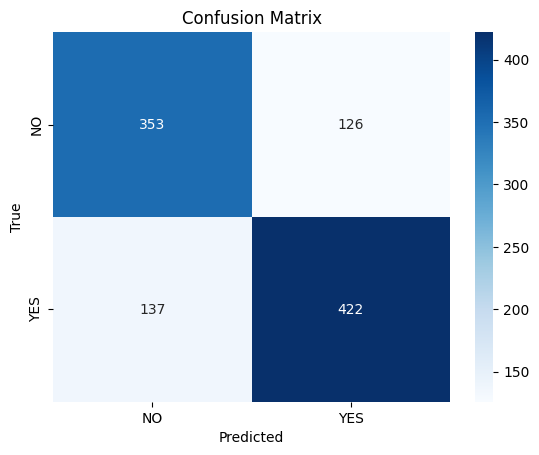


Top 10 Sexist Terms (Positive Weight):
<StringArray>
[    'women',   'mujeres',     'mujer', 'feminismo',       'las',    'hombre',
      'cock',     'whore',      'look',       'men']
Length: 10, dtype: str

Top 10 Safe Terms (Negative Weight):
<StringArray>
[       'co',     'https',    'people', 'womensday',   'deserve',  'igualdad',
      'amor',     'shirt', 'beautiful',   'jornada']
Length: 10, dtype: str

Total Errors: 263
Example Errors (False Negatives - Sexism missed):
<StringArray>
[                                                                                              '@Fichinescu La comunidad gamer es un antro de misóginos y supremacistas blancos hace años pero hoy día pocos se acuerdan de gamergate y todo lo que causó, y en cierto sentido sigue causando.',
                                                                                                                                                                                       '@Ds_OutOfContext Micromachis

In [7]:
# ==========================================
# 6. FINAL ERROR ANALYSIS (Section 5)
# ==========================================
print("\n--- 5 ERROR ANALYSIS ---")
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_val)

print(classification_report(y_val, y_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# Top Discriminative Features
vect = final_model.named_steps['vect']
clf = final_model.named_steps['clf']
feature_names = vect.get_feature_names_out()
coefs = clf.coef_[0]

df_feats = pd.DataFrame({'term': feature_names, 'weight': coefs})
print("\nTop 10 Sexist Terms (Positive Weight):")
print(df_feats.sort_values('weight', ascending=False).head(10)['term'].values)
print("\nTop 10 Safe Terms (Negative Weight):")
print(df_feats.sort_values('weight', ascending=True).head(10)['term'].values)

# Qualitative Analysis
results_val = pd.DataFrame({'text': X_val, 'true': y_val, 'pred': y_pred})
errors = results_val[results_val['true'] != results_val['pred']]
print(f"\nTotal Errors: {len(errors)}")
print("Example Errors (False Negatives - Sexism missed):")
print(errors[errors['true']==1].head(3)['text'].values)